In [42]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


# Membaca dan menyiapkan data

In [43]:
# 1. Baca dan siapkan data
df = pd.read_csv('data_pelanggan_sampel.csv')
df['Tanggal Transaksi Terakhir'] = pd.to_datetime(df['Tanggal Transaksi Terakhir'])
df['Tanggal Transaksi Pertama'] = pd.to_datetime(df['Tanggal Transaksi Pertama'])
today = pd.Timestamp(datetime.today().date())

print(df.head())

      ID Pelanggan  Kode Pos Tanggal Transaksi Pertama  \
0  112345678900001     80236                2023-01-15   
1  112345678900002     80236                2022-09-20   
2  112345678900003     80236                2023-03-05   
3  112345678900004     80236                2022-06-10   
4  112345678900005     80236                2023-08-25   

  Tanggal Transaksi Terakhir  Frekuensi Pembelian  Total Pembelian (Rp)  
0                 2024-12-10                    8              10500000  
1                 2024-12-20                   10              17500000  
2                 2024-12-01                    5               7200000  
3                 2024-11-15                   12              19300000  
4                 2025-01-10                    6               9800000  


## Menghitung RFMT (Recency, Frequency, Monetary, Tenure)

Kita ingin memahami seberapa "berharga" setiap pelanggan. Maka kita hitung 4 hal yang sering dipakai dalam dunia bisnis:

### Recency: Seberapa lama sejak pelanggan terakhir membeli?

- Kalau pelanggan terakhir belanja 10 hari yang lalu, berarti masih aktif.
- Tapi kalau sudah 400 hari tidak beli, artinya sudah lama tidak aktif.

### Frequency: Seberapa sering pelanggan melakukan pembelian?
- Kalau beli 1 kali doang = kurang setia.
- Kalau beli 10 kali = sering belanja.

### Monetary: Total uang yang dibelanjakan oleh pelanggan.
- Semakin besar total uangnya, makin bernilai pelanggan tersebut.

### Tenure: Sudah berapa lama pelanggan tersebut bersama kita (dari pembelian pertamanya).
- Misal pelanggan sudah beli sejak 2 tahun lalu, berarti "umur" pelanggannya panjang.


In [44]:
#2 Hitung RFMT
df['Recency'] = (today - df['Tanggal Transaksi Terakhir']).dt.days
df['Frequency'] = df['Frekuensi Pembelian']
df['Monetary'] = df['Total Pembelian (Rp)']
df['Tenure'] = (today - df['Tanggal Transaksi Pertama']).dt.days

print (df[['Recency', 'Frequency', 'Monetary', 'Tenure']].head())

   Recency  Frequency  Monetary  Tenure
0      155          8  10500000     850
1      145         10  17500000     967
2      164          5   7200000     801
3      180         12  19300000    1069
4      124          6   9800000     628


## Agregasi per kode pos

- Di sini, kita ingin menganalisis pelanggan berdasarkan area tempat tinggalnya, yaitu berdasarkan kode pos.
- Kita menggabungkan (mengelompokkan) data berdasarkan 'Kode Pos'. Misalnya, semua pelanggan yang tinggal di 80114 digabung jadi satu baris.

Kenapa setiap nilai diperlakukan berbeda?
- Recency = kita ambil nilai minimum (yang paling baru belanjanya di area itu). Karena semakin kecil angkanya, berarti masih aktif.
- Frequency & Monetary = kita jumlahkan, karena kita ingin tahu total pembelian dan frekuensinya untuk satu area.
- Tenure = kita ambil maksimum (umur pelanggan tertua), karena itu memberi gambaran loyalitas tertinggi di daerah itu.

In [45]:
# 3. Agregasi per kode pos
rfmt_agg = df.groupby('Kode Pos').agg({
    'Recency': 'min',
    'Frequency': 'sum',
    'Monetary': 'sum',
    'Tenure': 'max'
}).reset_index()

## Normalisasi Nilai RFMT dengan Z-Score

Tujuan: Menyamakan skala antar nilai Recency, Frequency, Monetary, dan Tenure.

Masalah saat ini:
- Recency bisa bernilai 10 (hari),
- Frequency bisa 200 kali,
- Monetary bisa 50 juta rupiah,
- Tenure bisa 800 hari.

Angka-angka ini besarannya beda-beda, jadi tidak bisa dibandingkan langsung. Kita butuh menyamakan skala.

### Solusinya: kita pakai metode bernama Z-score.
Z-score merupakan “nilai standar” yang memberitahu kita:
“Seberapa jauh nilai ini dari rata-rata?”

Contoh:
- Jika R_z = -1 -> berarti recency di kode pos ini lebih kecil dari rata-rata (pelanggan masih baru belanja).
- Jika F_z = +2 -> berarti frekuensinya jauh di atas rata-rata (pelanggan sering belanja).


# Mengubah Z-Score Menjadi Skor 1–5

Tujuan: Mengubah angka Z-score yang bisa negatif/positif menjadi angka diskrit (bulat) dari 1 sampai 5.

### Kenapa?
Karena kita akan melakukan segmentasi pelanggan, jadi kita butuh angka bulat yang mudah dibaca dan dibagi ke dalam kategori.


Kita akan membagi data jadi 5 kelompok ukuran sama:
- Kelompok dengan nilai paling kecil -> mendapat skor 1
- Kelompok dengan nilai paling tinggi -> mendapat skor 5

Misalnya:
- Kolom Recency -> makin kecil makin bagus (berarti baru saja belanja) -> nilai rendah = skor tinggi
- Tapi karena Z-score bisa + dan −, kita tidak pusing bolak-balik — cukup biarkan Python membaginya ke dalam 5 bagian.

In [46]:
# 4. Z-score normalization
scaler = StandardScaler()
rfmt_values = rfmt_agg[['Recency', 'Frequency', 'Monetary', 'Tenure']]
rfmt_scaled = scaler.fit_transform(rfmt_values)
rfmt_scaled_df = pd.DataFrame(rfmt_scaled, columns=['R_z', 'F_z', 'M_z', 'T_z'])

print(rfmt_scaled_df.head())

        R_z       F_z       M_z       T_z
0 -0.796098  1.460993  1.502321  1.873180
1  1.779513  0.495579  0.326609 -0.863609
2 -0.796098 -0.920361 -0.982574 -0.103390
3 -1.498537  1.042647  1.035177  0.352742
4  0.842927 -1.242166 -1.190630 -0.589930


In [47]:
# 5. Skor 1-5 berdasarkan z-score (binned secara kuantil)
rfmt_scores = rfmt_scaled_df.copy()
for col in rfmt_scores.columns:
    rfmt_scores[col] = pd.qcut(rfmt_scores[col], 5, labels=[1, 2, 3, 4, 5])


In [48]:
# 6. Gabungkan ke data utama
rfmt_final = pd.concat([rfmt_agg, rfmt_scores], axis=1)
rfmt_final.rename(columns={'R_z': 'R', 'F_z': 'F', 'M_z': 'M', 'T_z': 'T'}, inplace=True)

print(rfmt_final.head())

   Kode Pos  Recency  Frequency   Monetary  Tenure  R  F  M  T
0     80236      122        123  200100000    1069  1  5  5  5
1     80237      133         93  140200000     979  5  4  3  1
2     80238      122         49   73500000    1004  1  2  2  3
3     80239      119        110  176300000    1019  1  5  5  4
4     80240      129         39   62900000     988  4  1  1  2


## Segmentasi manual

Sekarang kita ingin memberi label atau "segmentasi" kepada setiap kode pos, berdasarkan kombinasi skor R, F, M, T:
- Pelanggan yang nilai R, F, dan M-nya tinggi kemungkinan besar adalah pelanggan terbaik.
- Pelanggan yang R-nya rendah (lama tak belanja) bisa jadi mulai "hibernasi" atau bahkan sudah "churn" (hilang).
- Pelanggan baru biasanya punya R tinggi, tapi F dan M masih rendah.

Kita bisa gunakan aturan manual berdasarkan pengalaman marketing.
Contoh:
- R ≥ 4, F ≥ 4, M ≥ 4 → Best Customer
- F ≥ 4 dan M ≥ 3 → Loyal Spender
- R = 1 dan F ≤ 2 → Hibernating

In [49]:
# 7. Segmentasi manual
def assign_segment(row):
    r, f, m, t = int(row['R']), int(row['F']), int(row['M']), int(row['T'])
    if r >= 4 and f >= 4 and m >= 4:
        return 'Best Customer'
    elif f >= 4 and m >= 3:
        return 'Loyal Spender'
    elif r >= 4 and (f >= 3 or t >= 3):
        return 'Potential Loyalist'
    elif r >= 4:
        return 'New Customer'
    elif f >= 4:
        return 'Loyal Customer'
    elif r >= 3 and f >= 2:
        return 'Promising'
    elif r >= 2 and (f >= 2 or t >= 2):
        return 'Can Not Lose'
    elif r == 2 and f <= 2:
        return 'About to Sleep'
    elif r == 1 and f <= 2:
        return 'Hibernating'
    else:
        return 'Churner'

rfmt_final['Segment'] = rfmt_final.apply(assign_segment, axis=1)

print (rfmt_final[['Kode Pos', 'Recency', 'Frequency', 'Monetary', 'Tenure', 'Segment']].head())


   Kode Pos  Recency  Frequency   Monetary  Tenure        Segment
0     80236      122        123  200100000    1069  Loyal Spender
1     80237      133         93  140200000     979  Loyal Spender
2     80238      122         49   73500000    1004    Hibernating
3     80239      119        110  176300000    1019  Loyal Spender
4     80240      129         39   62900000     988   New Customer


In [50]:
# 8. Tampilkan hasil RFMT asli
print("\nSkor RFMT (nilai asli sebelum diskretisasi):")
print(rfmt_final[['Kode Pos', 'Recency', 'Frequency', 'Monetary', 'Tenure']].head(10))


Skor RFMT (nilai asli sebelum diskretisasi):
   Kode Pos  Recency  Frequency   Monetary  Tenure
0     80236      122        123  200100000    1069
1     80237      133         93  140200000     979
2     80238      122         49   73500000    1004
3     80239      119        110  176300000    1019
4     80240      129         39   62900000     988
5     80241      124         92  148900000    1024
6     80242      131         28   44800000     942
7     80243      127         56   87300000     997
8     80244      122         79  126200000    1013
9     80245      125        107  175400000    1039


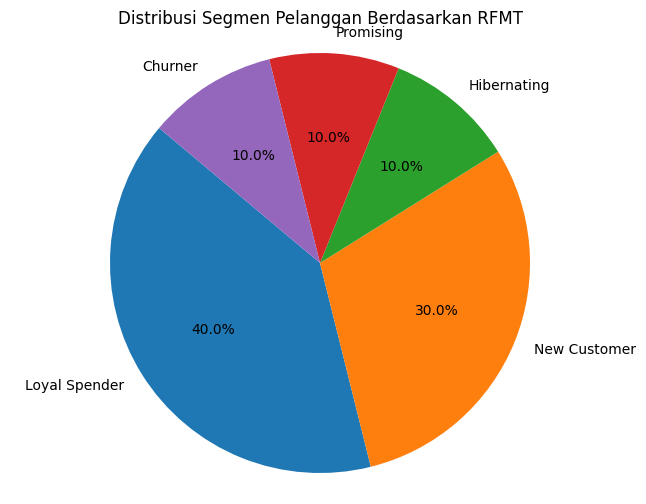

In [51]:
# 9. Visualisasi pie chart segmen pelanggan
import matplotlib.pyplot as plt

segment_counts = rfmt_final['Segment'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Segmen Pelanggan Berdasarkan RFMT')
plt.axis('equal')
plt.show()

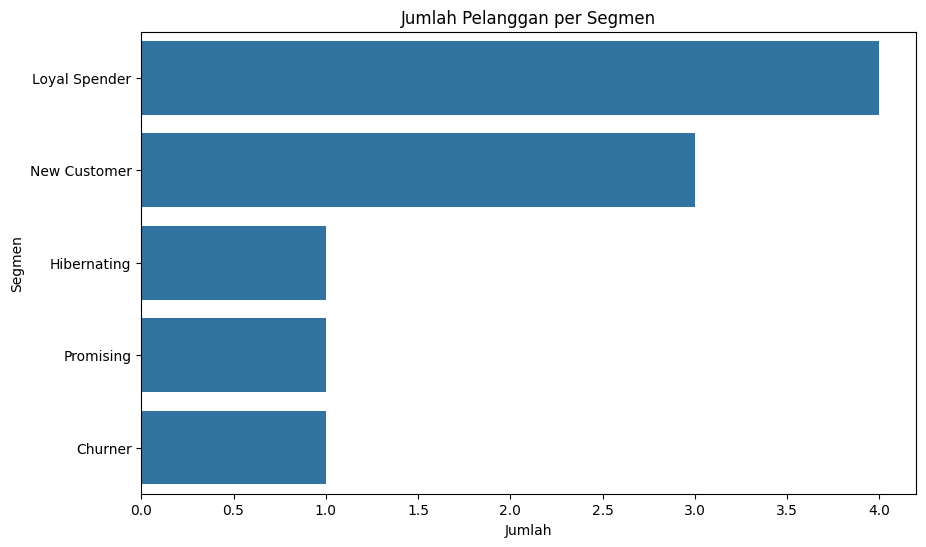

In [52]:
# 10. Bar chart untuk jumlah pelanggan per segmen
plt.figure(figsize=(10, 6))
sns.countplot(data=rfmt_final, y='Segment', order=rfmt_final['Segment'].value_counts().index)
plt.title('Jumlah Pelanggan per Segmen')
plt.xlabel('Jumlah')
plt.ylabel('Segmen')
plt.show()